In [4]:
# made by Gibeom LEE, HI LAB
# 우선 offset 된 데이터를 baseline correction 해줍니다. (앞 뒤 n % 기준으로)
# 전류 데이터를 적분하여 전하로 만들어줍니다.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
import os
file_path = r"C:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\2. Collecting data\250417_야간측정\코팅유무\uncoat_2.csv"


Offset: 0.129165


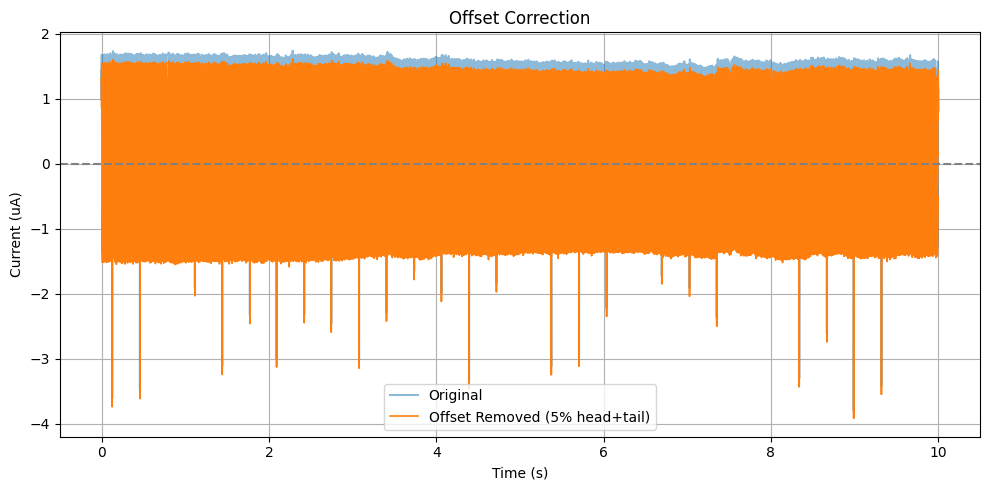

In [15]:
# === 사용자 설정: 얼마나 앞뒤 비율 사용할 것인지 (%) ===
fraction_percent = 5  # 앞뒤 몇 %를 baseline 추정에 사용할지 조정 ####여기에서 오차 발생이 생길 수 있음.

# 파일 불러오기
#file_path = r"C:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\2. Collecting data\250417_야간측정\2nd try\A-DEG (ctype)\확대 전류\Extend_I_Ctype_2-1.csv"

df = pd.read_csv(file_path, header=None, skiprows=30)

df.columns = ['Time', 'Current']
# 데이터 형식 변환...글자 -> NaN
df["Time"] = pd.to_numeric(df["Time"], errors='coerce')
df["Current"] = pd.to_numeric(df["Current"], errors='coerce')

# === 전류 시계열 추출 ===
current = df['Current'].values
n_total = len(current)
n_fraction = int(n_total * (fraction_percent / 100))

# === 앞쪽과 뒤쪽 데이터로 baseline 계산 === ###여기서도 잘 조절해봐.
front_section = current[:n_fraction]
back_section = current[-n_fraction:]
baseline_offset = np.mean(np.concatenate([front_section, back_section]))
print(f"Offset: {baseline_offset:4f}")

# === offset 제거 ===
Cor_current = current - baseline_offset
df['Cor_current'] = Cor_current

# === 결과 시각화 ===
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Current'], label='Original', alpha=0.5)
plt.plot(df['Time'], df['Cor_current'], label=f'Offset Removed ({fraction_percent}% head+tail)', linewidth=1.2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Current (uA)")
plt.title("Offset Correction")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.ylim(-16,3)
plt.show()

df["Current"] = df["Cor_current"]

I_max: 32.213501 μA
I_min: -78.286499 μA
I_pp: 110.500000 μA


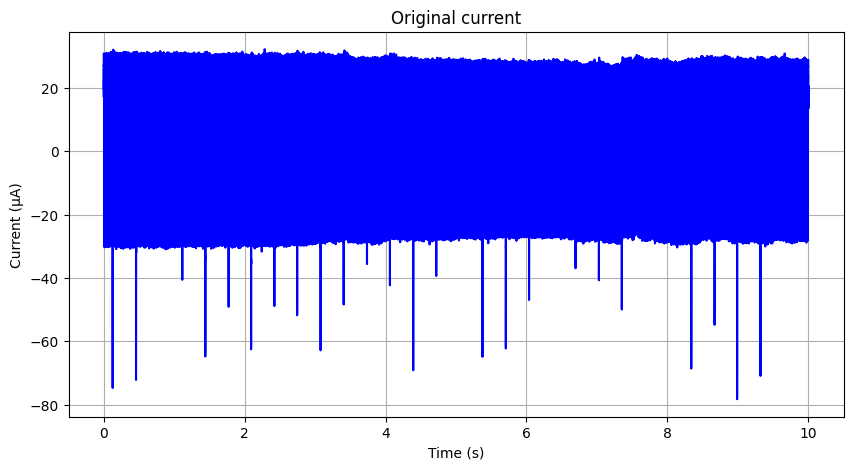

In [12]:

#    *ex) (10) = 10 μA/V 기준  %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 
df["Current"] = df["Current"]*(20)

print(f"I_max: {df.iloc[:, 1].max(skipna=True):.6f} μA")
print(f"I_min: {df.iloc[:, 1].min(skipna=True):.6f} μA")
print(f"I_pp: {df.iloc[:, 1].max(skipna=True)-df.iloc[:, 1].min(skipna=True):.6f} μA")

plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:, 0], df.iloc[:, 1], label="AC current", color='b')
plt.xlabel("Time (s)")
plt.ylabel("Current (μA)")
plt.title("Original current")
#plt.ylim(-60,60)
plt.grid(True)
plt.show()


양수 전하 값: 14776.178574 nC
음수 전하 값: -14725.143634 nC


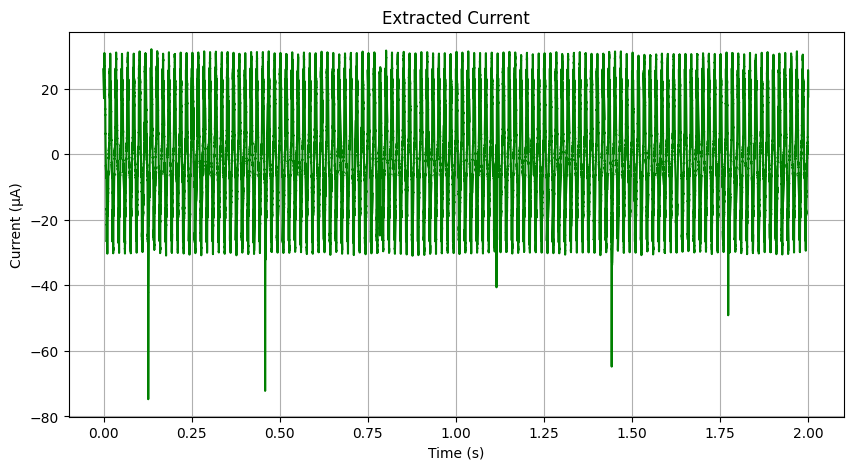

In [8]:
# 2. 특정 범위 선택      ########################## MUST BE MODIFIED MANUALLY
time_range = (0, 2) #unit = sec
df_filtered = df[(df.iloc[:, 0] >= time_range[0]) & (df.iloc[:, 0] <= time_range[1])]

# 양수/음수 분리
p_value = df_filtered[df_filtered["Current"] > 0]
n_value = df_filtered[df_filtered["Current"] < 0]
p_time = p_value["Time"].values
p_current = p_value["Current"].values
n_time = n_value["Time"].values
n_current = n_value["Current"].values

# 전하 적분 함수 정의 (1개 포인트도 대응)
def segment_and_integrate(current, time, df_full, threshold=0.01, scale_factor=1e3):
    if len(time) < 1:
        return 0.0
    total_charge = 0.0
    group_start = 0
    time_diffs = np.diff(time)
    for i, dt in enumerate(time_diffs):
        if dt > threshold:
            segment_t = time[group_start:i+1]
            segment_i = current[group_start:i+1]
            if len(segment_t) > 1:
                total_charge += scale_factor * cumulative_trapezoid(segment_i, segment_t, initial=0)[-1]
            elif len(segment_t) == 1:
                dt_est = 1e-6
                t0 = segment_t[0]
                if t0 in df_full["Time"].values:
                    idx = df_full.index[df_full["Time"] == t0].tolist()[0]
                    if 0 < idx < len(df_full) - 1:
                        dt_est = (df_full.iloc[idx + 1]["Time"] - df_full.iloc[idx - 1]["Time"]) / 2
                total_charge += scale_factor * segment_i[0] * dt_est
            group_start = i + 1
    if group_start < len(time):
        segment_t = time[group_start:]
        segment_i = current[group_start:]
        if len(segment_t) > 1:
            total_charge += scale_factor * cumulative_trapezoid(segment_i, segment_t, initial=0)[-1]
        elif len(segment_t) == 1:
            dt_est = 1e-6
            t0 = segment_t[0]
            if t0 in df_full["Time"].values:
                idx = df_full.index[df_full["Time"] == t0].tolist()[0]
                if 0 < idx < len(df_full) - 1:
                    dt_est = (df_full.iloc[idx + 1]["Time"] - df_full.iloc[idx - 1]["Time"]) / 2
            total_charge += scale_factor * segment_i[0] * dt_est
    return total_charge

# 적분 수행
p_charge = segment_and_integrate(p_current, p_time, df)
n_charge = segment_and_integrate(n_current, n_time, df)

print(f"양수 전하 값: {p_charge:.6f} nC")
print(f"음수 전하 값: {n_charge:.6f} nC")

plt.figure(figsize=(10, 5))
plt.plot(df_filtered.iloc[:, 0], df_filtered.iloc[:, 1], label="Current", color='g')
plt.xlabel("Time (s)")
plt.ylabel("Current (μA)") ### 단위 고려 중요
plt.title("Extracted Current")
#plt.ylim(-0.01, 0.01)
#plt.legend()
plt.grid(True)
plt.show()


-26.90285007550299

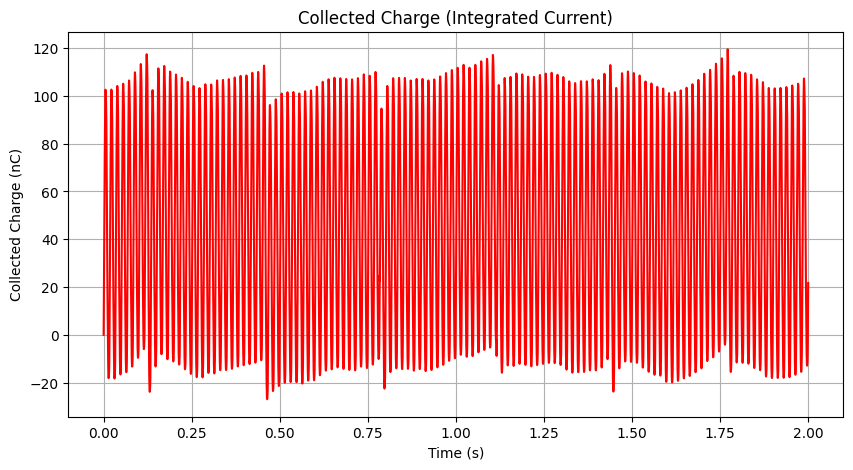

Filtered data saved at: C:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\2. Collecting data\250417_야간측정\코팅유무\Charge_uncoat_2.csv


In [9]:
# 6. 누적 전류 적분 수행
cumulative_charge = 1e3 * cumulative_trapezoid(df_filtered["Current"], df_filtered["Time"], initial=0)
print(np.min(cumulative_charge))
# 7. 누적 전하 그래프 플로팅
plt.figure(figsize=(10, 5))
plt.plot(df_filtered["Time"], cumulative_charge, label="Cumulative Charge", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Collected Charge (nC)")  # 단위 중요
plt.title("Collected Charge (Integrated Current)")
plt.grid(True)
plt.show()

# 8. 필터링된 데이터 저장
folder_path = os.path.dirname(file_path)
original_filename = os.path.basename(file_path)
filtered_file_name = f"Charge_{original_filename}"
filtered_file_path = os.path.join(folder_path, filtered_file_name)
df_filtered.to_csv(filtered_file_path, index=False)

print(f"Filtered data saved at: {filtered_file_path}")
